# Python exercise: investigating corporate credit ratings and stock performance during the COVID-19 crash
Nicolas Dolce - August 30, 2020

## A brief Python investigation using Pandas

This is the first in a series of posts meant to demonstrate my skills as an aspiring data scientist. Throughout the series, we will try to answer interesting questions related to finance, sustainable business, and natural language processing. 

Today we we will compare the aggregate performance of different credit rating segments from the S&P 500 during the spring 2020 COVID-19 market crash and recovery. We will be working with two datasets, one that shows the daily stock price for the companies in the S&P 500 index and one that includes their credit ratings in February and July 2020 and their market capitalizations.

### Background information
First, let's cover some essentials. The **Standard and Poor 500** or **S&P 500** is a stock market index which tracks the stock performance of the 500 largest publically traded companies in the USA. 

We are interested in the index's performance during the **COVID-19 pandemic**. The S&P 500 hit a high of 3,386 on February 19, 2020, but by March 23,3030 the index had dropped almost 34% to 2,237 in response to COVID concerns. Thanks to unprecedented financial intervention by the Fed, by August 21, 2020 the S&P 500 had recovered its losses and was again setting new highs.

Next, **corporate credit ratings** are used to indicate how likely a corporation is to pay back debts to investors. Our analysis uses Standard and Poor's ratings, which range from from AAA, meaning the corporations financials are very good shape, to BBB-, indicating a weak financial situation with lots of uncertainty and risk. We will be looking at credit ratings provided by Standard and Poors for the constituent companies of the S&P 500 in February of 2020.

In our dataset, the credit ratings range from best to worst as follows: AAA, AA+, AA, AA-, A+, A, A-, BBB+, BBB, BBB-, BB+, BB, BB-, B+, B, and NR for Not Rated.

Finally, **market capitalization** (shortened to **market cap**) is the total value of a company's shares. If a company has 1,000,000 shares and they trade at USD 5 each, the market cap is USD 5,000,000.

With this information in mind, we can set out to investigate how the companies' credit rating affected their performance during the 2020 market crash. As a general prediction, one might expect companies with higher credit ratings, meaning they were on stable financial footing in February 2020, to have performed better during the market crash ... but let's see what the data say! 

This is meant to be a simple, informal analysis to demonstrate the steps of a Python data analysis, so we will rely on visualizations to make our conclusions rather proper statistical inference.

### Importing the data
Our data are divided into two csv files: `spx_daily_2.24.20_7.30.20.csv`, which contains the daily stock price for each company in the index between February 24 and July 30, 2020, and `spx_credit_rating_and_mkt_cap.csv`, which includes each company's credit rating in February 2020 and July 2020, as well as each company's market cap on July 30, 2020. First, let's import our csv files using `pandas` and take a look at our data using the `info()` and `head()` functions. We will leave out the column 'End_Rating' since we are only interested in 'Start_Rating' and 'Market_Cap'.

In [15]:
import pandas as pd
import numpy as np

files = ['spx_daily_2.24.20_7.30.20.csv', 'spx_credit_rating_and_mkt_cap.csv']

#import the csv files using pandas, assigning index names, column names, and data types; leave out 'End_Rating'
spx_daily_prices = pd.read_csv(files[0], sep=',', index_col = 'DATES')
spx_credit_marketcap = pd.read_csv(files[1], sep=',', index_col = 'Security', header = 0,
                                  names = ['Security','Start_Rating', 'End_Rating', 'Market_Cap'],
                                   usecols = ['Security', 'Start_Rating', 'Market_Cap'],
                                  dtype = {'Start_Rating': 'str', 'Market_Cap':np.float64})

#display the info() for each df
print('The daily prices df:')
print(spx_daily_prices.info(), '\n')

print('The credit rating and market cap df:')
print(spx_credit_marketcap.info())

The daily prices df:
<class 'pandas.core.frame.DataFrame'>
Index: 159 entries, 2/24/2020 to 7/31/2020
Columns: 505 entries, LYB UN Equity to DISCK UW Equity
dtypes: float64(505)
memory usage: 628.5+ KB
None 

The credit rating and market cap df:
<class 'pandas.core.frame.DataFrame'>
Index: 505 entries, LYB UN Equity to DISCK UW Equity
Data columns (total 2 columns):
Start_Rating    446 non-null object
Market_Cap      505 non-null float64
dtypes: float64(1), object(1)
memory usage: 11.8+ KB
None


Right off the bat we can see that the indices are swapped. In the first dataframe, each row represents a date, and each column is a company. In the second dataframe, each row is a company, and the columns hold the credit ratings and market capitalization information. We will have to keep this in mind when we combine the dataframes.

We can also note the presence of around 19 `NaN` values in the `'Start_Rating'` column of the second dataset. This means we will have to address these `NaN` values in some way during our data preparation step.  Options like entering an average are not available with discrete data, so let's just remove these companies.

To get a better idea of how the data actually looks, let's use the `head()` function to view the first 10 rows. Let's also check what kind of unique values we get in the `'Start_Rating'` column of the credit rating and market cap dataframe.

In [16]:
# display the first ten rows of each df
print('The daily prices df:')
display(spx_daily_prices.head(10))

print('The credit rating and market cap df:')
display(spx_credit_marketcap.head(10))

print('Unique values in "Start_Rating" column:')
display(spx_credit_marketcap['Start_Rating'].unique())

The daily prices df:


,LYB UN Equity,AXP UN Equity,VZ UN Equity,AVGO UW Equity,BA UN Equity,CAT UN Equity,JPM UN Equity,CVX UN Equity,KO UN Equity,ABBV UN Equity,...,ALGN UW Equity,ILMN UW Equity,LKQ UW Equity,NLSN UN Equity,GRMN UW Equity,ZTS UN Equity,EQIX UW Equity,DLR UN Equity,LVS UN Equity,DISCK UW Equity
DATES,,,,,,,,,,,,,,,,,,,,,
2/24/2020,79.65,128.19,57.99,291.60,317.90,132.17,132.16,104.71,58.65,93.14,...,240.11,281.12,32.330,21.38,95.36,138.39,644.90,135.27,62.21,27.13
2/25/2020,75.41,120.90,57.12,282.68,304.14,129.00,126.26,100.71,57.82,89.18,...,229.61,269.95,31.320,20.42,92.00,134.82,631.98,133.54,60.16,26.30
2/26/2020,74.39,118.50,57.14,285.88,305.59,128.25,126.64,98.04,57.60,88.41,...,227.54,274.70,30.540,20.29,90.38,136.15,629.84,130.38,59.16,25.42
2/27/2020,70.90,112.81,55.06,273.95,287.76,123.27,121.37,94.13,54.93,85.42,...,223.97,259.93,29.720,18.58,89.28,133.95,597.49,123.19,58.43,23.79
2/28/2020,71.46,109.93,54.16,272.62,275.11,124.24,116.11,93.34,53.49,85.71,...,218.35,265.67,29.580,18.21,88.39,133.23,572.80,120.11,58.31,25.10
2/29/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3/1/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3/2/2020,74.52,113.87,57.32,284.97,289.27,127.60,121.52,96.59,55.92,88.69,...,230.22,278.28,29.900,18.12,93.47,138.91,618.88,130.49,58.26,25.17
3/3/2020,72.24,108.01,55.70,274.25,280.62,124.38,116.96,94.39,56.06,87.57,...,224.56,273.00,28.730,17.58,90.07,137.24,615.16,129.59,55.90,25.08


The credit rating and market cap df:


,Start_Rating,Market_Cap
Security,,
LYB UN Equity,BBB+,2.162277e+10
AXP UN Equity,BBB+,7.508127e+10
VZ UN Equity,BBB+,2.396347e+11
AVGO UW Equity,BBB-,1.311084e+11
BA UN Equity,A-,9.293648e+10
CAT UN Equity,A,7.138405e+10
JPM UN Equity,A-,2.908938e+11
CVX UN Equity,AA,1.609709e+11
KO UN Equity,A+,2.003822e+11


Unique values in "Start_Rating" column:


array(['BBB+', 'BBB-', 'A-', 'A', 'AA', 'A+', 'BB+', 'BBB', 'AA+', 'AAA',
       'AA-', 'BB', nan, 'BB-', 'NR', 'BBu', 'B+', 'B', 'BBBu'],
      dtype=object)

In addition to the point on swapped axes and `NaN` values listed above, there are a few more things to note:
* To take advantage of pandas time series analysis funcitonality, we should convert the index of the daily_prices dataframe to `datetime` format.
* We see that the companies are referenced by their sticker name, e.g. VZ for Verizon, in both datasets, which will make combining the datasets easier. They appear to be sorted in the same manner, too, but we can make sure by alphabetizing them.
* The daily stock prices for the weekends have been included and will need to be removed in the data preparation stage.
* Besides `NaN`, we also see ratings like 'BBu' and 'BBBu' in the `'Start_Rating'` column. This distinction is unnecessary, so we will merge these ratings with 'BB' and 'BBB,' respectively.  

### Cleaning and preparing the data

In this case we will transpose the daily_prices index to be able to match and sort the indices. We must transpose this one because this is the only information the datasets have in common. Seems counterintuitive. Maybe there is a better way.

Remove the 'u' character by using the `replace()` function with regular expression functionality

Great, let's take those steps now with the code below.

In [17]:
import datetime

#convert prices index to datetime format
spx_daily_prices.index = pd.to_datetime(spx_daily_prices.index, format = '%m/%d/%Y')

#change BBu and BBBu to BB and BBB (remove 'u') :
spx_credit_marketcap.loc[:,'Start_Rating'].replace('u$', '', regex=True, inplace=True)

#transpose prices to be able to match index
spx_daily_prices = spx_daily_prices.transpose()
spx_daily_prices.index.name = 'Security'

#sort both dataframes' indices alphabetically to be able to match them
spx_daily_prices.sort_index(inplace=True)
spx_credit_marketcap.sort_index(inplace=True)

#join credit df with prices df into new dataframe
spx_cred_prices = spx_credit_marketcap.join(spx_daily_prices, how = 'left')

#drop rows that are missing the credit rating
spx_cred_prices = spx_cred_prices.dropna(subset = ['Start_Rating'])

#check that only rows with legitimate credit ratings are left
print(spx_cred_prices.Start_Rating.unique())
print(spx_cred_prices.info())

#remove weekend dates
spx_cred_prices.dropna(axis=1, how='all', inplace=True)

['BBB+' 'BB-' 'BBB-' 'AA+' 'A-' 'A+' 'A' 'BBB' 'AA' 'BB+' 'NR' 'BB' 'AA-'
 'B+' 'B' 'AAA']
<class 'pandas.core.frame.DataFrame'>
Index: 446 entries, A UN Equity to ZTS UN Equity
Columns: 161 entries, Start_Rating to 2020-07-31 00:00:00
dtypes: float64(160), object(1)
memory usage: 564.5+ KB
None


**Bingo**. We have successfully created a new dataframe with NaN weekend prices and credit rating values removed and BBBu and BBu corrected. Data preprocessing has been a success!

### Processing the data

Next, let's think about the task at hand. We want to group the companies by their credit rating, provide a weight for each company based on its market cap, and then normalize the price data to see a percentage based performance over the chosen time frame.

To provide a weight for each company based on its market cap, we need to divide each company's market cap by its credit rating group's total market cap. 

For example: American Express, under the ticker AXP, has a credit rating of BBB+, and a market cap of USD 75,081,270,000, or around 75 billion dollars. Verizon, under the ticker VZ, also has the credit rating BBB+, and a market cap of USD 239,634,700,000, or around 239 billion dollars. Imagining for a moment that these two companies are the only BBB+ entries in our dataset, the BBB+ group's total market cap would be 75 + 239 = USD 314 billion.

If we wanted to track the stock price movement of an index of this two-member BBB+ group, AXP would account for 23.8% (75 / 314) of the index's movement and VZ for 76.2% of the movement. So if the index was at 100 on day 1, and VZ doubled its share price the next day, the index would rise to 172.

An elegant solution to accomplish this arithmetic is to calculate the total market cap for each group and store this in a dictionary called `group_mktcaps`. Then we can used `pandas'` `map()` function (which matches a key to a value in a dictionary) to divide each company's market cap by the total market cap for each company's group. 

In [18]:
#get each group's total market cap and turn it into a dictionary
#groupby Start_Rating, and sum the Market_Cap column
group_mktcaps = spx_cred_prices.groupby(by = ['Start_Rating'])['Market_Cap'].sum().to_dict()

#create the Weight column by dividing each company's market cap by the group's market cap
spx_cred_prices['Weight'] = spx_cred_prices['Market_Cap'].div(spx_cred_prices['Start_Rating'].map(group_mktcaps), axis = 0)

#display the head of the spx_cred_prices dataframe to see the weight column
display(spx_cred_prices.head())

,Start_Rating,Market_Cap,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,...,2020-07-21 00:00:00,2020-07-22 00:00:00,2020-07-23 00:00:00,2020-07-24 00:00:00,2020-07-27 00:00:00,2020-07-28 00:00:00,2020-07-29 00:00:00,2020-07-30 00:00:00,2020-07-31 00:00:00,Weight
Security,,,,,,,,,,,,,,,,,,,,,
A UN Equity,BBB+,3.020460e+10,80.50,77.95,78.11,77.43,77.07,81.97,80.32,84.35,...,96.02,96.35,96.66,94.81,97.27,95.30,97.10,95.93,96.33,0.010006
AAL UW Equity,BB-,5.919652e+09,25.45,23.12,22.31,20.60,19.05,18.86,17.85,18.53,...,11.47,11.36,11.77,11.39,11.39,11.77,11.40,11.18,11.12,0.022503
AAP UN Equity,BBB-,1.050753e+10,139.91,137.60,134.54,134.13,132.98,132.99,130.33,132.90,...,147.38,149.40,148.37,147.27,146.83,146.19,148.21,152.87,150.14,0.010200
AAPL UW Equity,AA+,1.877303e+12,298.18,288.08,292.65,273.52,273.36,298.81,289.32,302.74,...,388.00,389.09,371.38,370.46,379.24,373.01,380.16,384.76,425.04,0.462429
ABBV UN Equity,A-,1.676239e+11,93.14,89.18,88.41,85.42,85.71,88.69,87.57,91.75,...,97.40,97.70,98.03,97.11,97.16,96.71,97.01,96.04,94.91,0.042421


Great. From the Weight column, which has been added as the last column, we can see for example that Apple (AAPL) makes up 46% of the AA+ group. Because the Weight columns is last, we will need to leave it out of our operations below by using the `:-1` slicing.

Next we want to normalize the daily price data by dividing each row by its price on the first date, February 24, 2020. This will enable us to see the percentage change each day in the analysis.

After that, we will multiply each row by its weight to receive the weighted daily performance of each company. All that remains then is to group the data again by credit rating, sum up each day's performance, and multiply by 100 to receive a normalized and weighty daily performance by credit rating.

In [19]:
#normalize the daily price data by dividing each row by the price on the first date
norm_spx_cred_prices = spx_cred_prices.iloc[:,2:-1].div(spx_cred_prices.iloc[:,2], axis = 0)

#multiply each row by its weight 
# iloc[-1] because weight column is last. 
wtd_norm_spx_cred_prices = norm_spx_cred_prices.mul(spx_cred_prices.iloc[:,-1], axis = 0)

#add the Start_Rating column back in to be able to sort by Start_Rating
full_wtd_norm_spx_cred_prices = wtd_norm_spx_cred_prices.join(spx_cred_prices['Start_Rating'], how='left')

#groupby the Start_Rating, leave out the Start_Rating column, sum it up, and multiply by 100
wtd_spx_bygroup = full_wtd_norm_spx_cred_prices.groupby('Start_Rating')[full_wtd_norm_spx_cred_prices.columns[:-1]].sum().mul(100, axis = 0)

Next, let's plot the data to get an initial idea of how each group's performance looks. First, we will transpose the dataframe so that each row is a credit rating group and column is a date, which makes it  use `Pandas`' built-in `plot()` functionality. We will then create the plot with a legend.

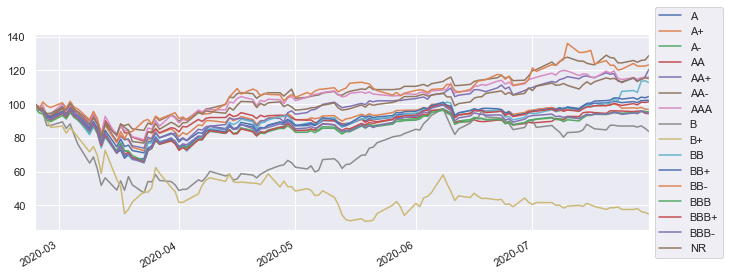

In [13]:
#let's plot this
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})

#transpose to make plotting easier (now each Column is a credit rating group)
wtd_spx_bygroupT = wtd_spx_bygroup.transpose()

#plot 
graph1 = wtd_spx_bygroupT.plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5)).get_figure()

### Interpretting the results

Great! At first glance we can see that there is indeed some variation. Some credit rating groups recovered their losses already in mid-April, whereas one is still down over 60% in late July.

This graph is a bit hard to interpret, however. There are lots of lines bunched together and the colors seem to overlap. What if we plot just a couple of them?

For example, one approach would be to chart the credit rating groups that reach the highest highs and the lowest lows.

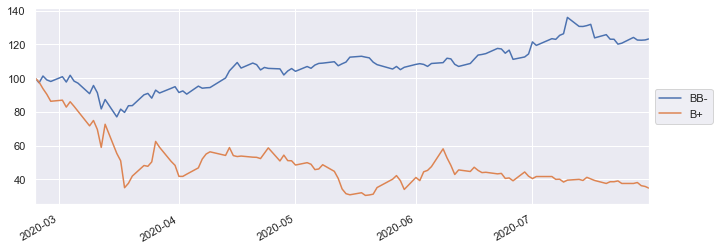

In [147]:
#find the credit rating group that reaches the absolute highest and the one that reaches the absolute lowest price
max_and_min = [wtd_spx_bygroupT.max().idxmax(), wtd_spx_bygroupT.min().idxmin()]

#select the desired columns
wtd_spx_subset = wtd_spx_bygroupT[max_and_min]

#plot the winning couple
graph2 = wtd_spx_subset.plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5)).get_figure()

So BB- reaches the highest high, and B+ reaches the lowest low. Interestingly enough, these two credit ratings are adjacent to each other towards the lower end of the pack. This suggests that the relationship between credit rating and stock price performance is not particularly strong. Otherwise we would expect AAA to be the best performer and B to be the lowest. 

Why did BB- chart so high? And why did B+ chart so high? Let's take a look at the constituent companies and their market caps?

In [14]:
print(spx_cred_prices[spx_cred_prices['Start_Rating'] == 'BB-'].index)
print(spx_cred_prices[spx_cred_prices['Start_Rating'] == 'B+'].index)

Index(['AAL UW Equity', 'IRM UN Equity', 'LB UN Equity', 'LYV UN Equity',
       'MGM UN Equity', 'NFLX UW Equity'],
      dtype='object', name='Security')
Index(['COTY UN Equity'], dtype='object', name='Security')


The beauty products company Coty Inc is the only stock in the B+ group, so the B+ really just tracks Coty's performance during our time period. To say the least, Coty's stock has seen better days (which makes sense, since all that working from home can't be good for cosmetic sales). 

BB- comprises American Airlines, enterprise information management company Iron Mountain Inc, fashion retail group L Brands (owner of Bath and Body Works and Victoria's Secret), Live Nation Entertainment, MGM Resorts International, and Netflix. What gives? Most of these are in tourism and entertainment and seem like they would have been terrible investments. Is there one outlier in BB- that had an especially strong performance? Let's find out. 

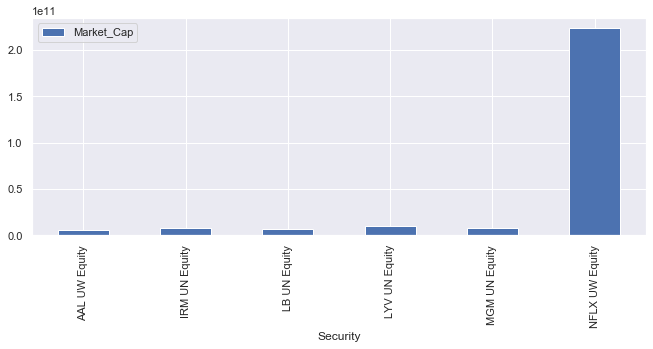

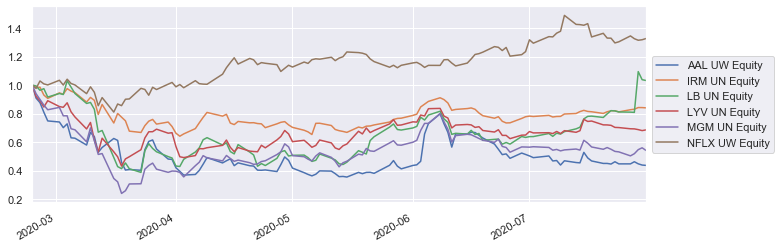

In [149]:
#create a bar chart of BB- market cap
BBm_subset = spx_cred_prices[spx_cred_prices['Start_Rating'] == 'BB-']
BBm_subset.plot.bar(y = 'Market_Cap')

#normalize BB- stocks by dividing by share price on first day
norm_BBm_subset = BBm_subset.iloc[:,2:-1].div(BBm_subset.iloc[:,2], axis = 0)

#transpose and plot BB- stock performances
BBm_graph = norm_BBm_subset.T.plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5)).get_figure()


Clearly, the strong performance of the BB- line almost entirely reflects the strong performance of Netflix, which makes up 84.8% of the group's market cap. Netflix's strong performance during the COVID quarantine certainly makes sense. More time at home in your PJs translates to more time for bingewatching Netflix.

A few important observations based on our investigation of the BB- and B+ groups. First, with such limited sample size for some of the credit ratings, there can be susbtantial sampling error and biases, making it impossible to generate any valid conclusions. Second, we can already posit that other (potentially related) factors than credit rating, such as the industry the company operates in, are more important in determining the stockprice performance during the COVID crisis.

With these caveats about data quality in mind, to reach an informal conclusion to our main question of how credit rating affects stock price performance, let's take one last look at the relationship between the two. We will adopt a simpler approach that we can visually interpret with ease: we will create a bar chart of the average stock price of each credit rating group during the entire time period, as well as the entire index average (a kind of informal one way analysis of variance approach). 

We will also reorder the columns according to match the credit rating score in descending order..

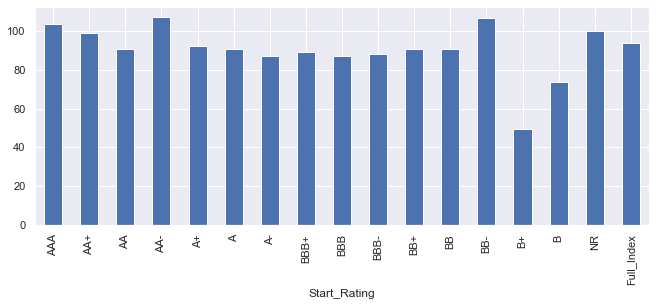

In [151]:
#generate weighted average performance for entire S&P500 index
#add the Index_Weight column for each company
spx_cred_prices['Index_Weight'] = spx_cred_prices['Market_Cap'].div(spx_cred_prices['Market_Cap'].sum(), axis = 0)

#normalize by dividing by first day
spx_index_mean = spx_cred_prices.iloc[:,2:-2].div(spx_cred_prices.iloc[:,2], axis = 0)

#multiply each row by its weight 
norm_spx_index_mean = spx_index_mean.mul(spx_cred_prices['Index_Weight'], axis=0)
final_spx_index_mean = norm_spx_index_mean.sum().mul(100, axis=0)

order = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-', 'BB+', 'BB', 'BB-', 'B+', 'B', 'NR', 'Full_Index']

#add this to the wtd_spx_bygroup
wtd_spx_bygroupT['Full_Index'] = final_spx_index_mean
reordered_wtd_spx_bygroupT = wtd_spx_bygroupT[order] 
averages_bygroup = reordered_wtd_spx_bygroupT.mean(axis = 0)
averages_bygroup.plot.bar()

### Conclusion

In general, we can see a slight downward tendency as the credit rating decreases, meaning that our prediction in the beginning was at least partially valid. However, the stock price performance does not strongly follow the creditworthiness, and from our exercise it seems to have more to do with variables not accounted for in the data here, such as industry (Coty and Netflix). 

This exercise was meant to demonstrate the steps involved in any data science project: importing the data, understanding the data, cleaning and preparing the data, processing the data, visualizing the results, investigating the initial findings, adjusting the investigation approach, and drawing conclusions.

One exercise for next time could be to complete a more thorough investigation of the determinants of stock price performance during the COVID crisis, with more data points, such as industry and other financial statistics beyond just market cap. Then, we could run a more proper statistical analysis and find correlation coefficients to determine which factors most strongly predict stock price performance.

Thanks for reading!